In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'

# analyze effective masses of K-conf.

In this notebook, we fit the effective masses of the baryons.

The total number of the measurements is 119,232, and
the number of the jack-knife samples is 20 (bin size 5,952 measurements).


In [3]:
import pickle
import scipy.optimize
import scipy.constants

In [4]:
hbarc = scipy.constants.hbar * scipy.constants.c / scipy.constants.electron_volt / scipy.constants.mega / scipy.constants.femto
ainv = 2.333e3 # lattice cut off [MeV]
lat_unit = hbarc/ainv # lattice spacing [fm]


In [5]:
bin_num = 20 # number of jack-knife samples
Nt = 96 

In [6]:
with open('../data/corr_jk_full_stat_20bins.pkl', 'rb') as fin:
    corr_jk = pickle.load(fin)

In [7]:
corr_jk.keys()

dict_keys(['proton', 'OMEGA', 'lambda', 'xi', 'sigma', 'delta', 'sigma*', 'xi*'])

In [8]:
def conv_meff(_corr_jk, nt_max=24):
    meff_jk = np.array([
        np.log(_corr_jk[:,it,1]/_corr_jk[:,it+1,1])
        for it in range(nt_max)])
    meff_jk_av = meff_jk.mean(axis=1)
    meff_jk_err = meff_jk.std(axis=1) * np.sqrt(bin_num - 1)
    return range(nt_max), meff_jk_av, meff_jk_err

In [9]:
meffs = {}
for key in ['proton', 'OMEGA', 'lambda', 'xi', 'sigma', 'delta', 'sigma*', 'xi*']:
    meffs[key] = conv_meff(corr_jk[key])

check all effective masses

Text(0,0.5,'$m_\\mathrm{eff}(t)$ [MeV]')

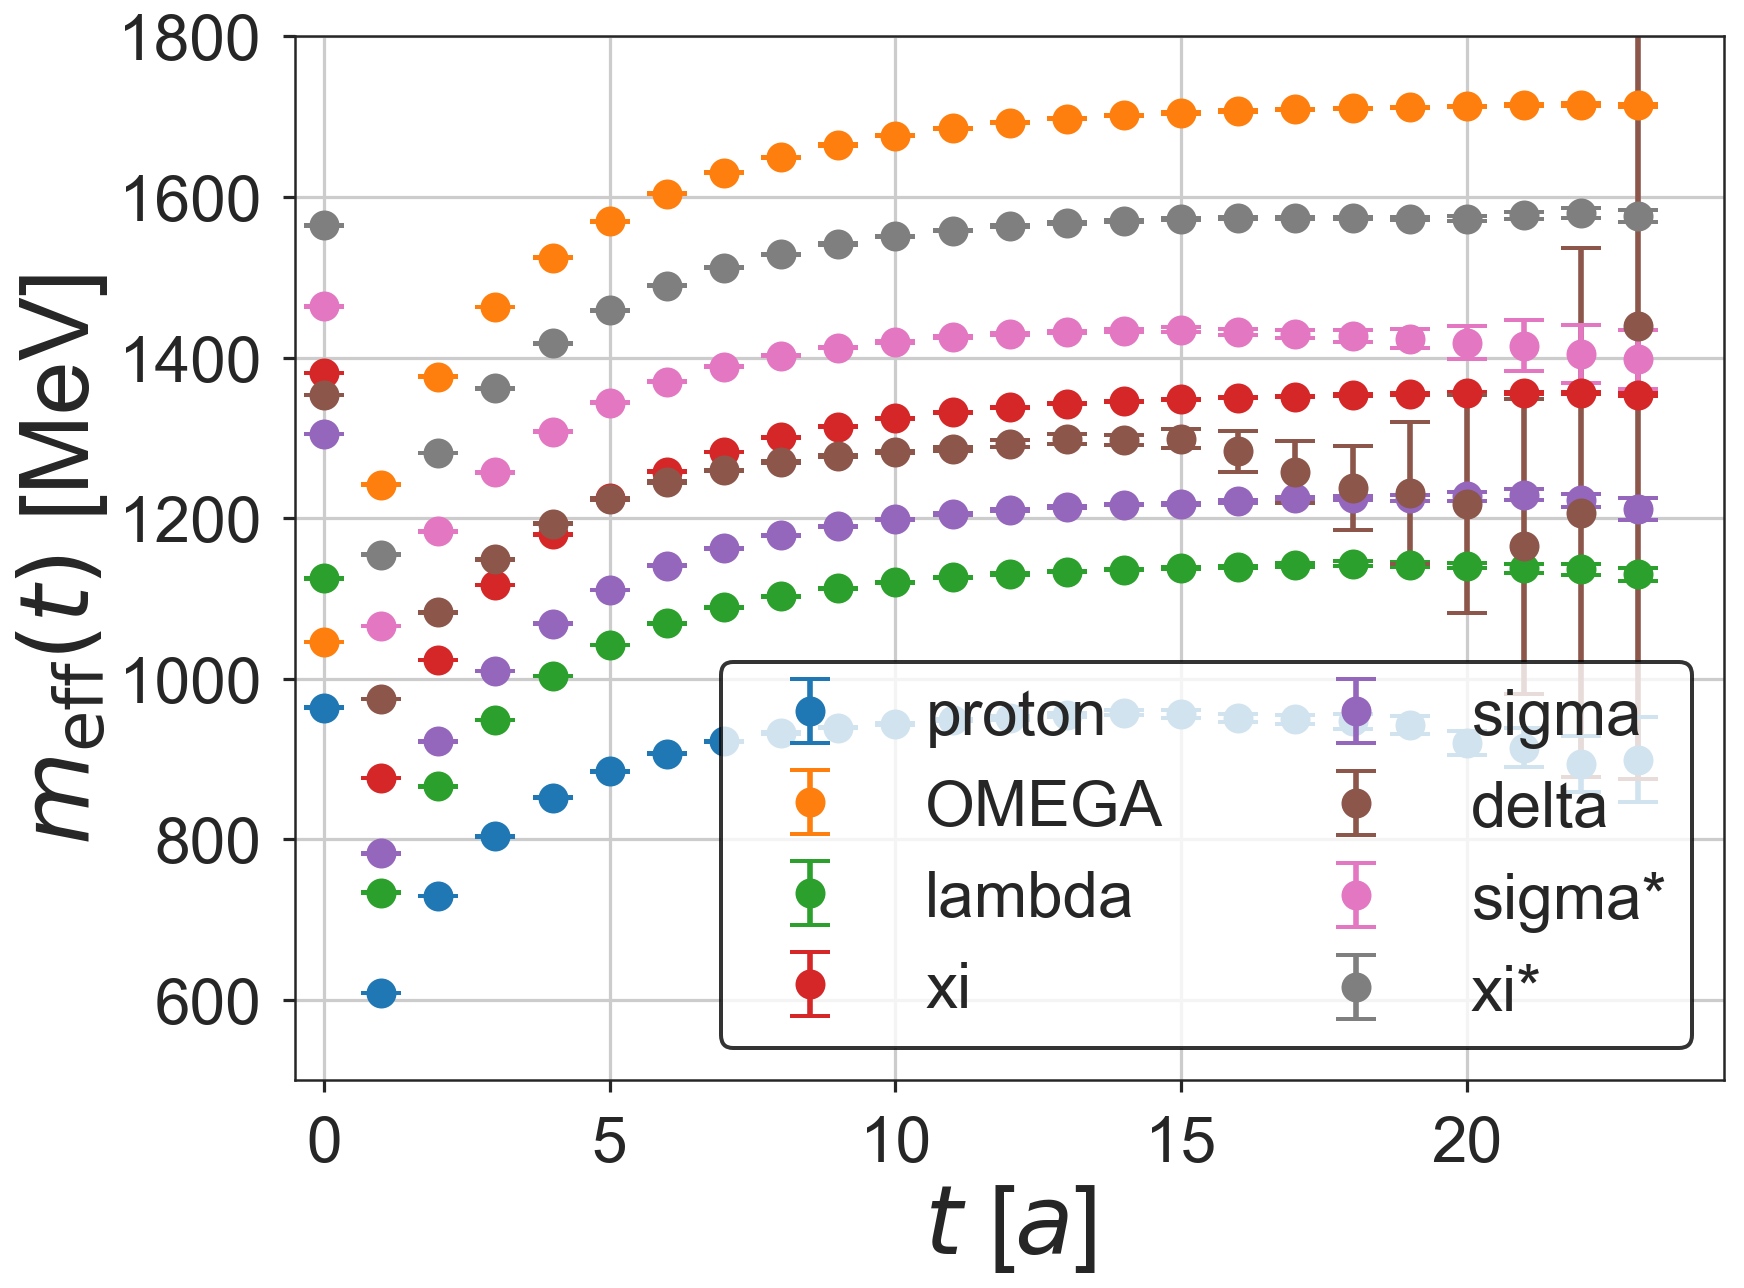

In [10]:
fig, ax = plt.subplots()
for key in meffs.keys():
    ax.errorbar(meffs[key][0], meffs[key][1] * ainv, 
               meffs[key][2] * ainv, 
                fmt='o', capsize=10, capthick=2.0, ms=15,
               label=key)
    
ax.set_xlim(-0.5, 24.5)
ax.set_ylim(500, 1800)
leg = ax.legend(ncol=2, frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_xlabel(r'$t$ [$a$]', size=48)
ax.set_ylabel(r'$m_\mathrm{eff}(t)$ [MeV]', size=48)

In [11]:
def fit_corr(tmp_corr_jk, fitr):
    ffit = lambda p, t: p[0] * np.exp(-p[1]*t)
    errf = lambda p, y, t, err: (ffit(p, t) - y)/err
    binNum = tmp_corr_jk.shape[0]
    meffs = []
    for ibin in range(binNum):
        data = tmp_corr_jk[ibin,:,:]
        mask = (data[:,0] >= fitr[0]) & (data[:,0] <= fitr[1])
        pfit = scipy.optimize.leastsq(errf, [0.1, 0.1],
                                     args=(data[mask,1], data[mask,0], data[mask,2]), full_output=True)
        meffs.append(pfit[0][1])
        
    meffs = np.array(meffs)
    return meffs.mean(), meffs.std() * np.sqrt(binNum - 1)

In [12]:
ch_label = {'proton': 'N', 'OMEGA': r'$\Omega$', 'delta': r'$\Delta$',
           'xi': r'$\Xi$', 'xi*': r'$\Xi^\ast$', 'lambda': r'$\Lambda$',
           'sigma': r'$\Sigma$', 'sigma*': r'$\Sigma^\ast$'}

In [13]:
mkdir -p ../figs/meff

fit effective mass and plot

In [14]:
def meff_fitting(ch, fitr, yr):
    fig, ax = plt.subplots()

    ax.errorbar(meffs[ch][0], meffs[ch][1]*ainv, meffs[ch][2]*ainv,
               fmt='o', capsize=10, capthick=2.5, ms=25, color='red',
                mfc='none', mew=2,
               label=ch_label[ch])

    meff_av, meff_err = fit_corr(corr_jk[ch], fitr)
    ax.plot(fitr, (meff_av*ainv, meff_av*ainv), lw=5, color='blue',
           label=r'{:3.2f} $\pm$ {:3.2f}'.format(meff_av*ainv, meff_err*ainv))
    ax.plot(fitr, ((meff_av+meff_err)*ainv, (meff_av+meff_err)*ainv), lw=1, ls='--', color='blue')
    ax.plot(fitr, ((meff_av-meff_err)*ainv, (meff_av-meff_err)*ainv), lw=1, ls='--', color='blue')
    ax.fill_between(fitr, ((meff_av+meff_err)*ainv, (meff_av+meff_err)*ainv), 
                          ((meff_av-meff_err)*ainv, (meff_av-meff_err)*ainv), color='blue', alpha=0.3)


    ax.set_xlim(9.5, 23.5)
    ax.set_ylim(yr)
    leg = ax.legend(frameon=True, fontsize=28)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_xlabel(r'$t$ [$a$]', size=48)
    ax.set_ylabel(r'$m_\mathrm{eff}$ [MeV]', size=48)
    fig.savefig('../figs/meff/meff_{}.pdf'.format(ch), bbox_inches='tight')

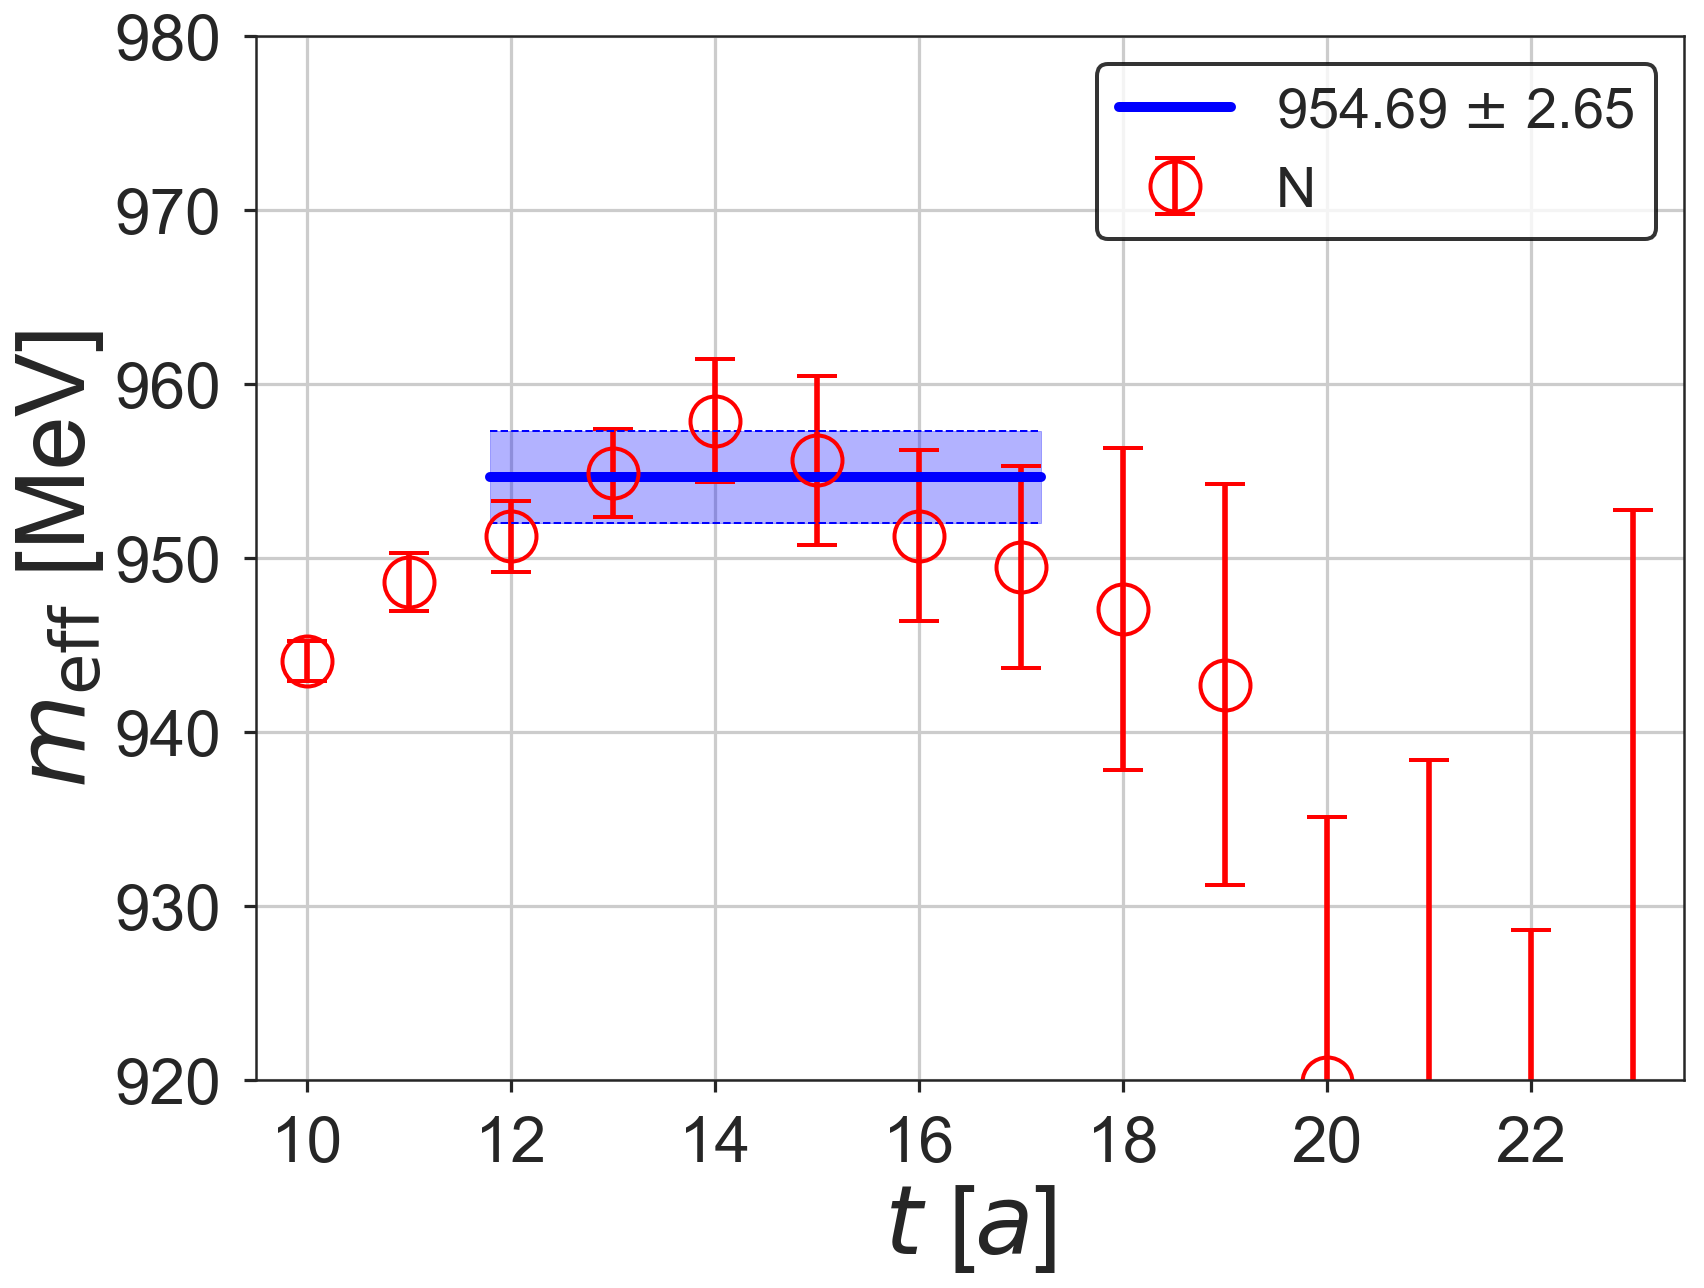

In [15]:
meff_fitting('proton', (11.8, 17.2), (920, 980))

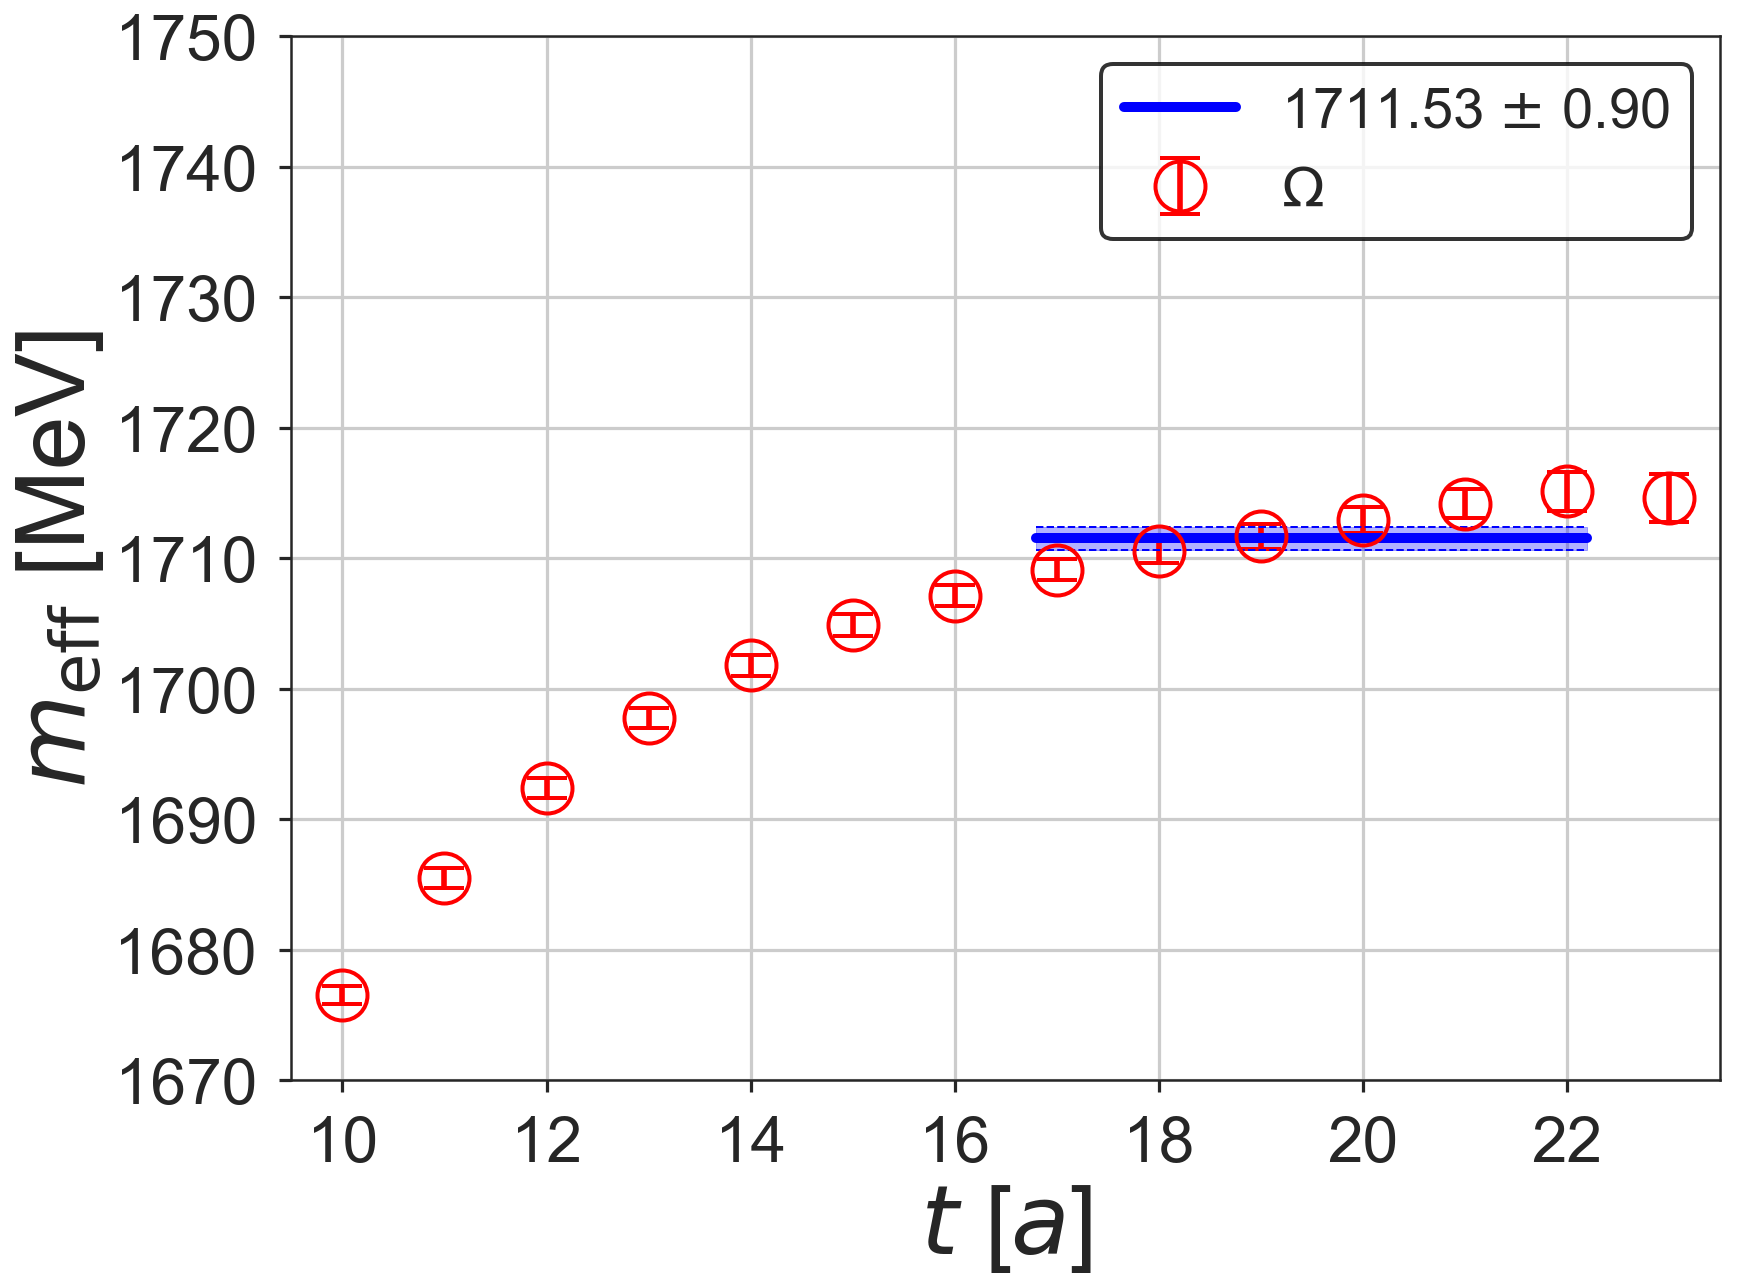

In [16]:
meff_fitting('OMEGA', (16.8, 22.2), (1670, 1750))

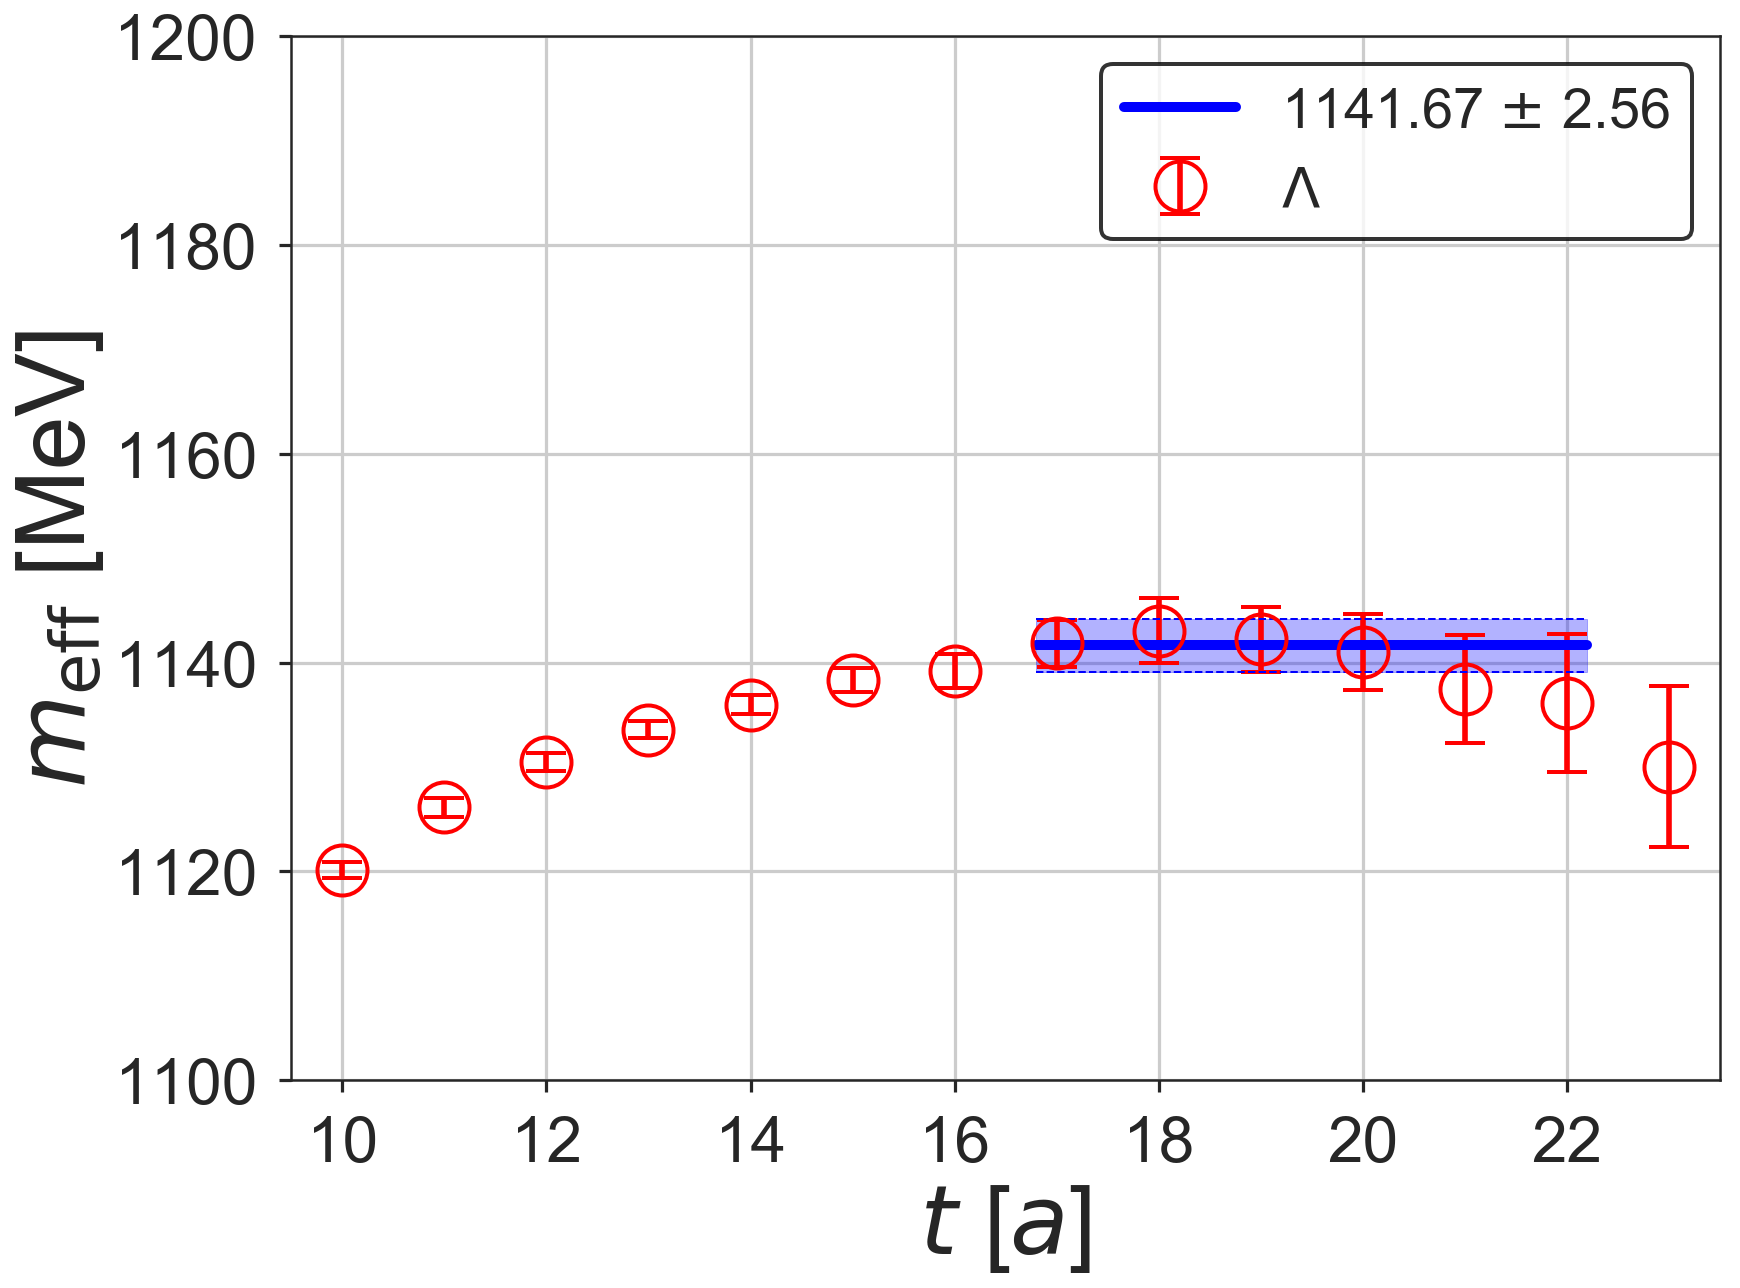

In [17]:
meff_fitting('lambda', (16.8, 22.2), (1100, 1200))

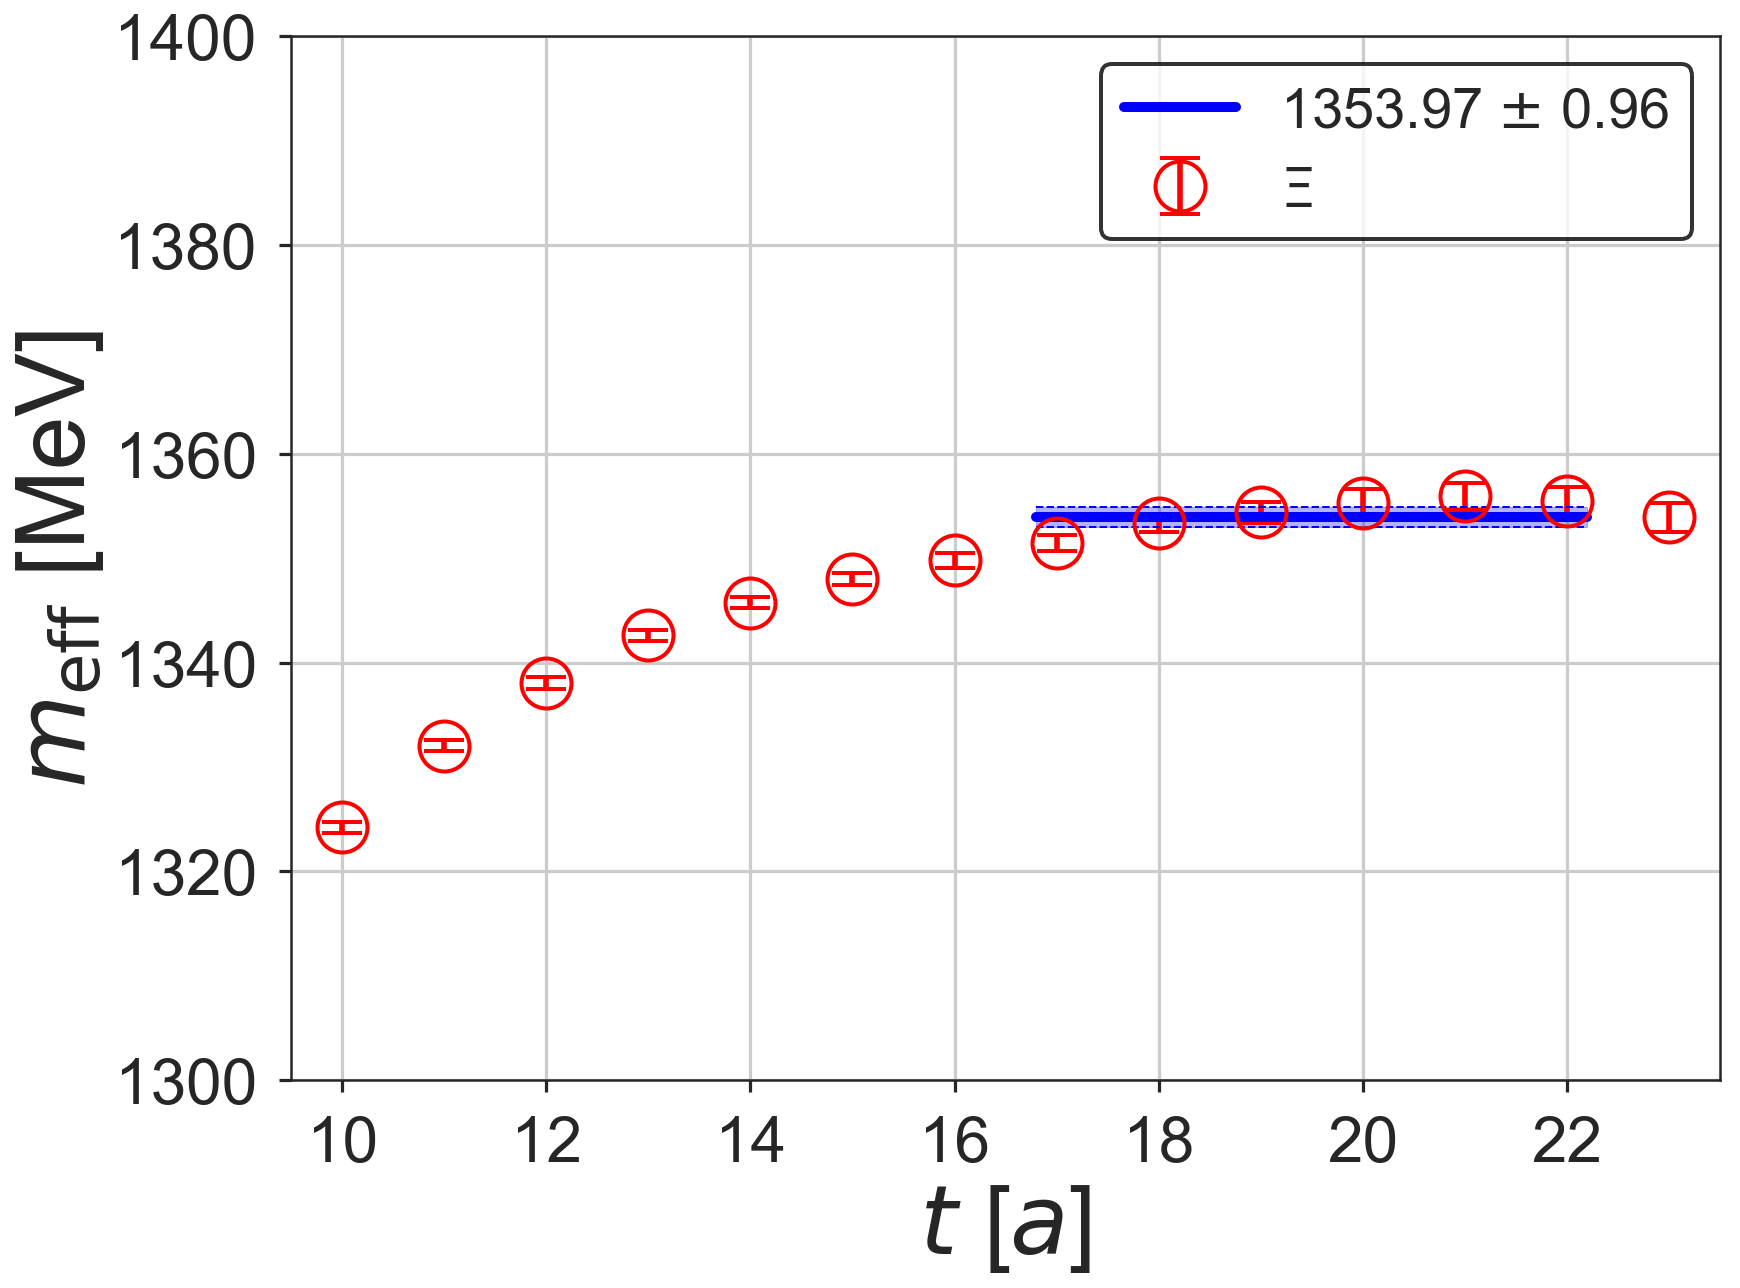

In [18]:
meff_fitting('xi', (16.8, 22.2), (1300, 1400))

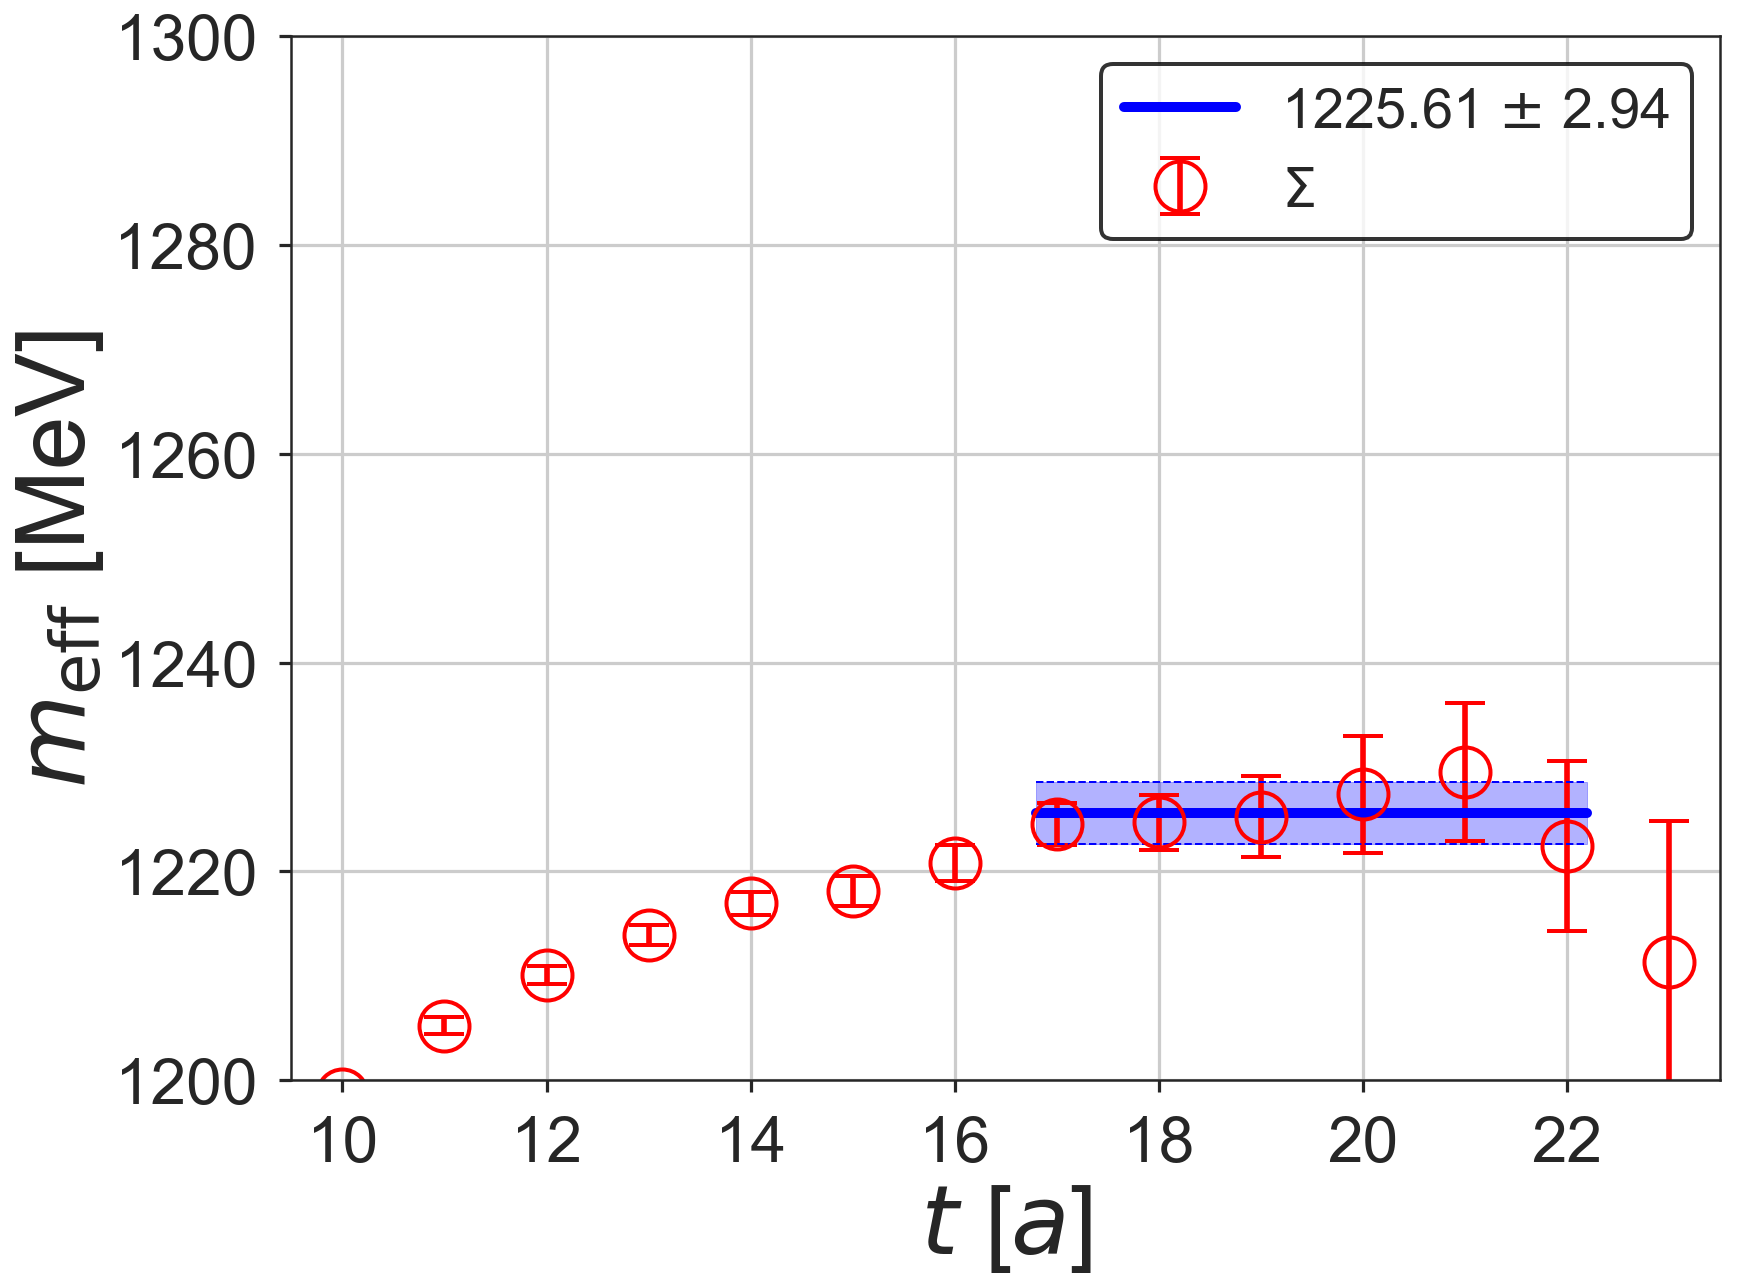

In [19]:
meff_fitting('sigma', (16.8, 22.2), (1200, 1300))

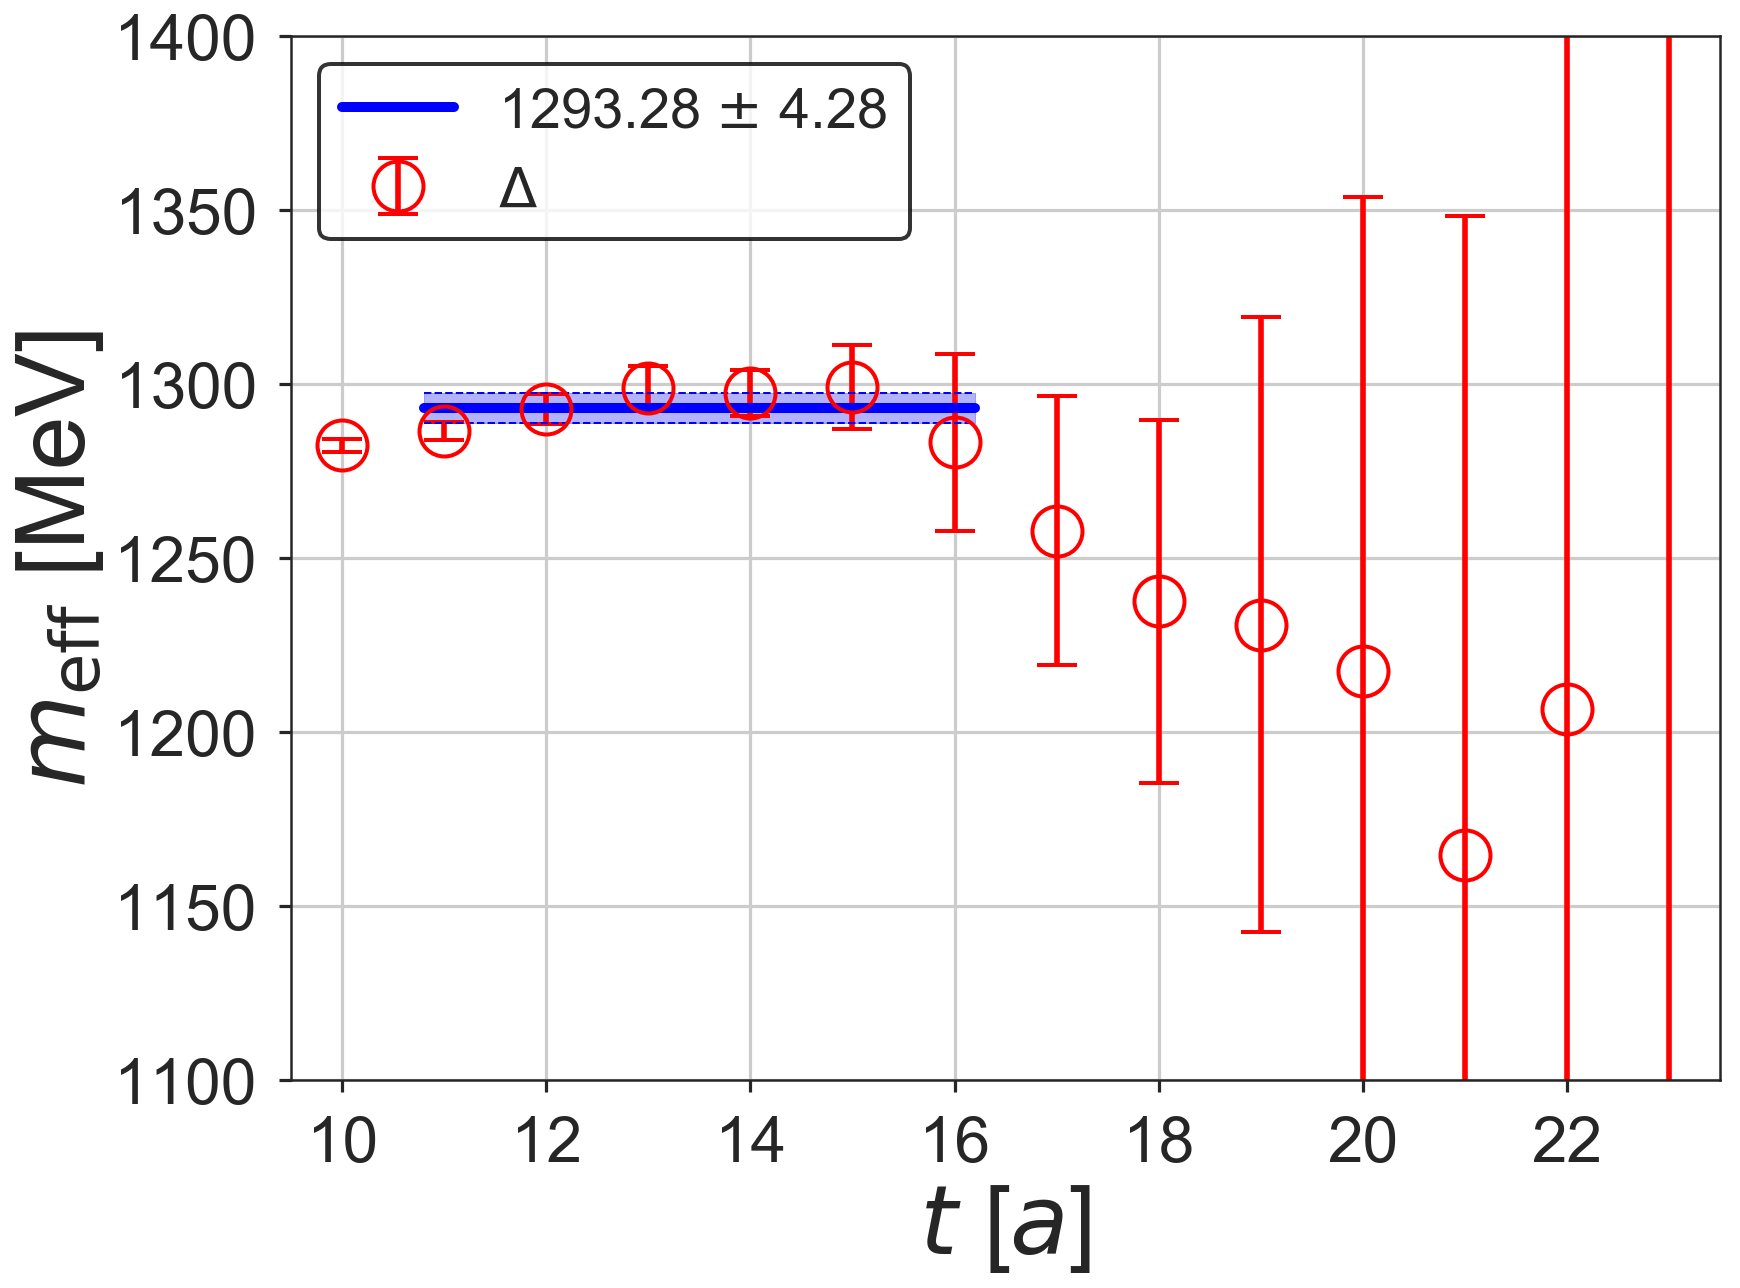

In [20]:
meff_fitting('delta', (10.8, 16.2), (1100, 1400))

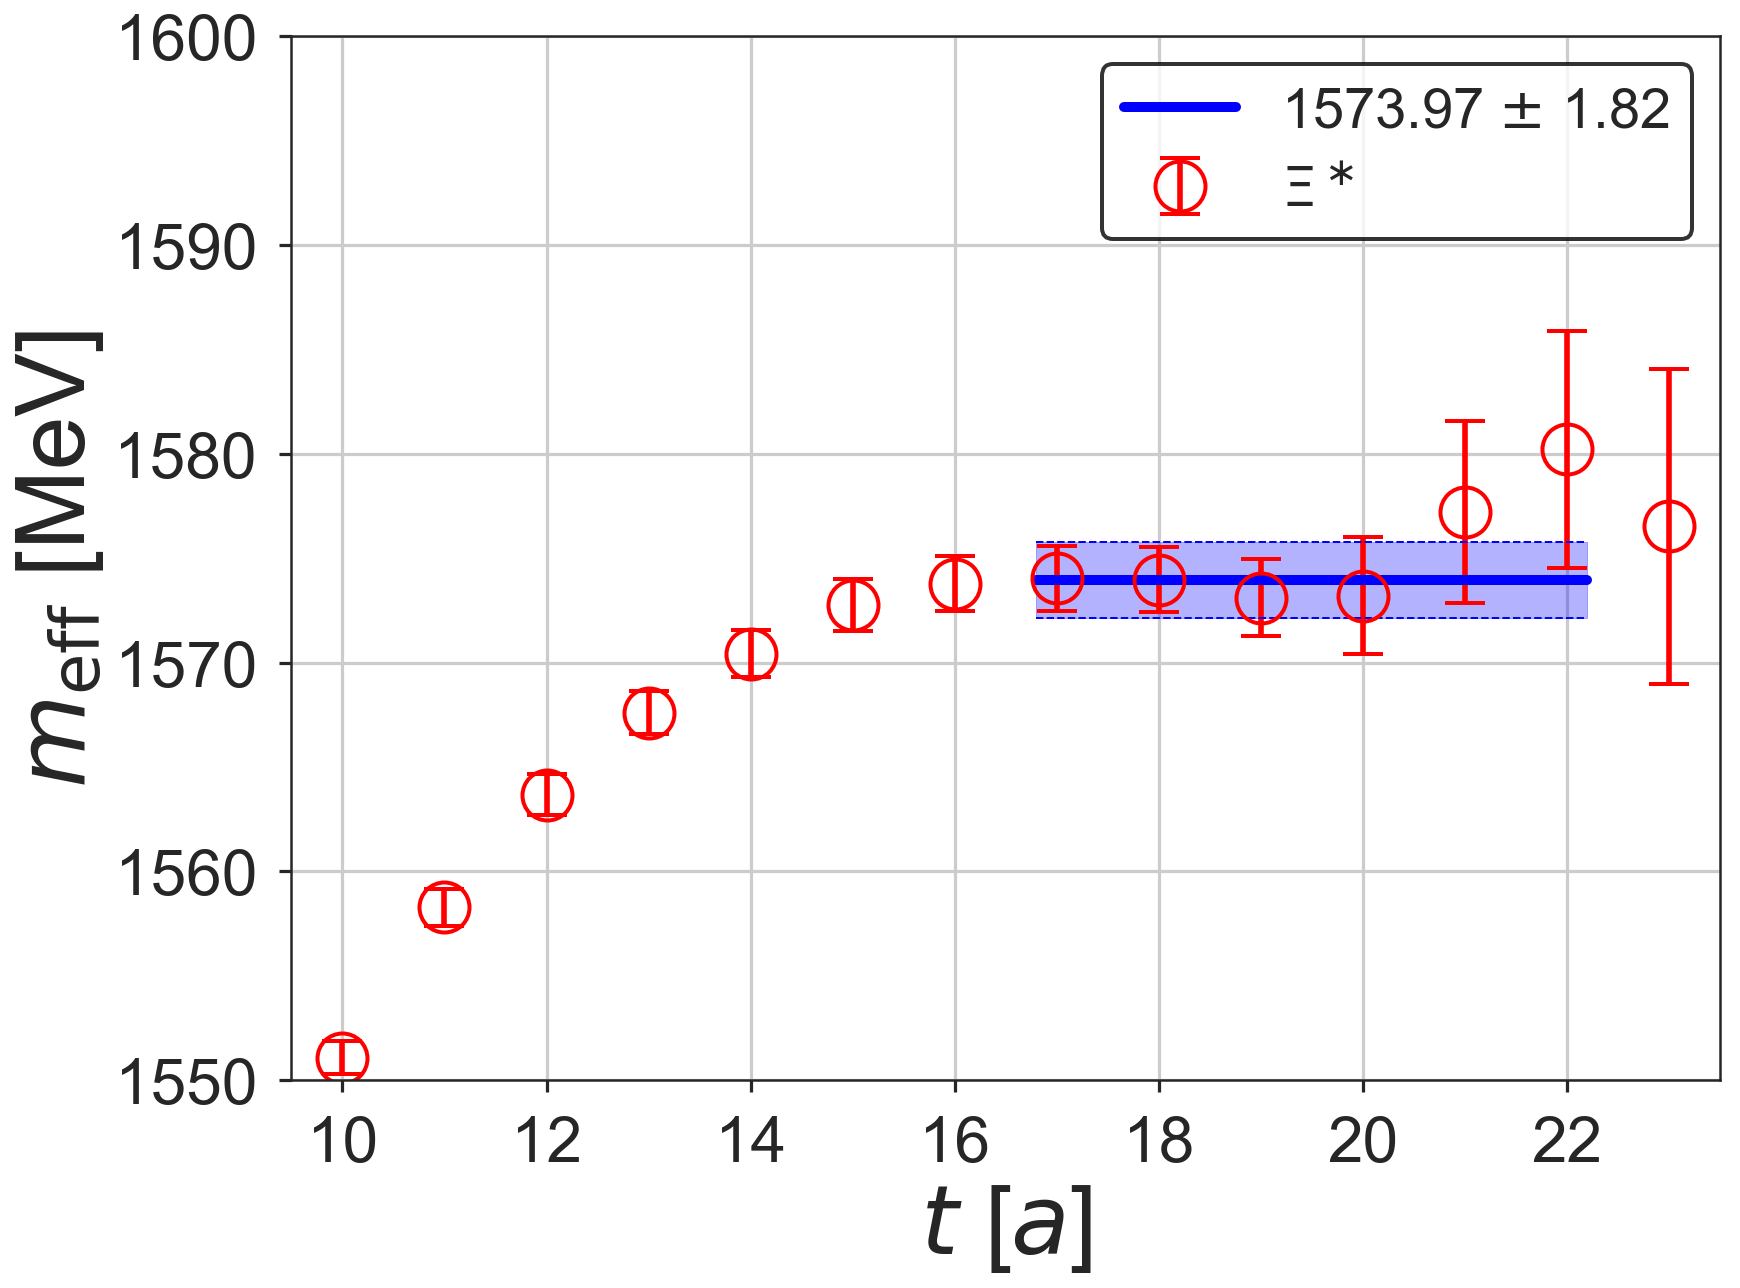

In [21]:
meff_fitting('xi*', (16.8, 22.2), (1550, 1600))

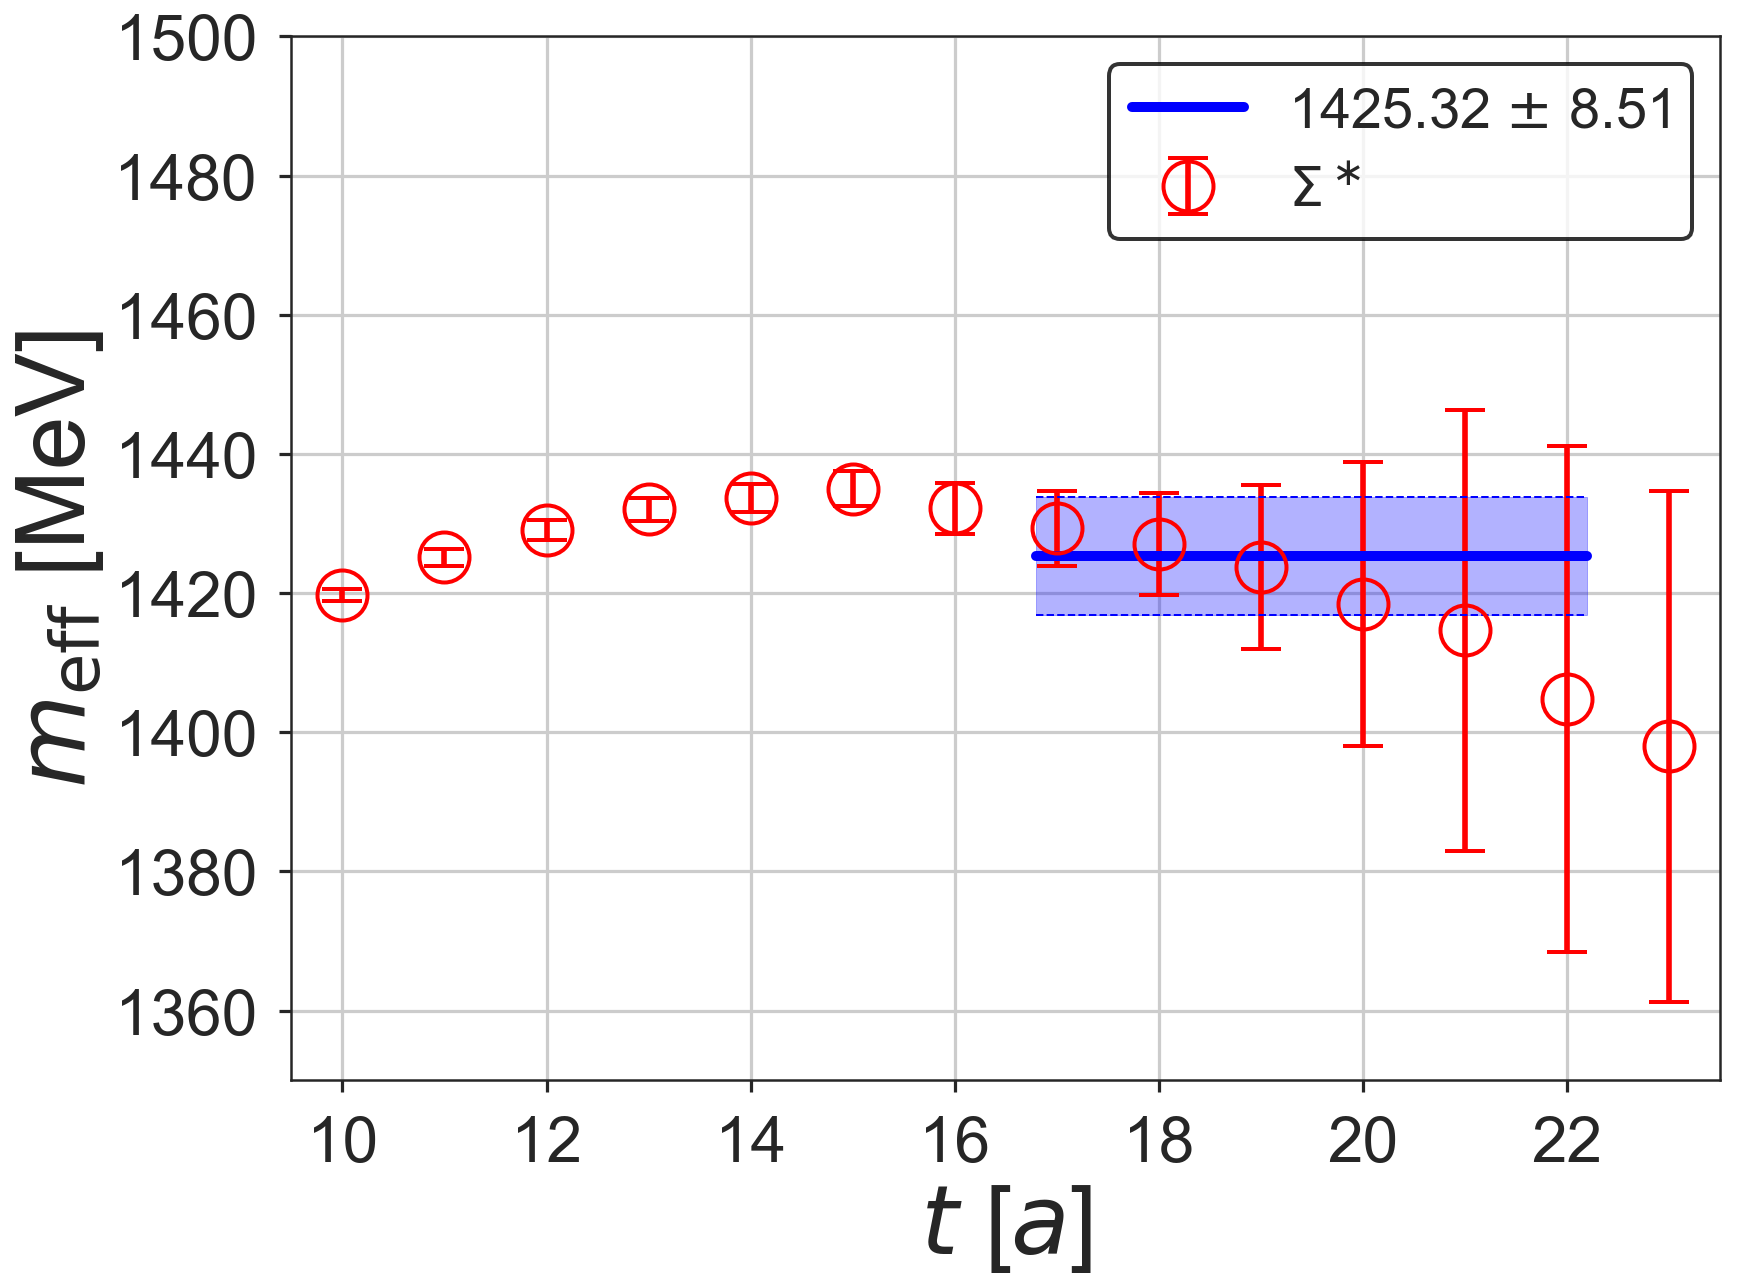

In [22]:
meff_fitting('sigma*', (16.8, 22.2), (1350, 1500))

check the convergence of the effective masses

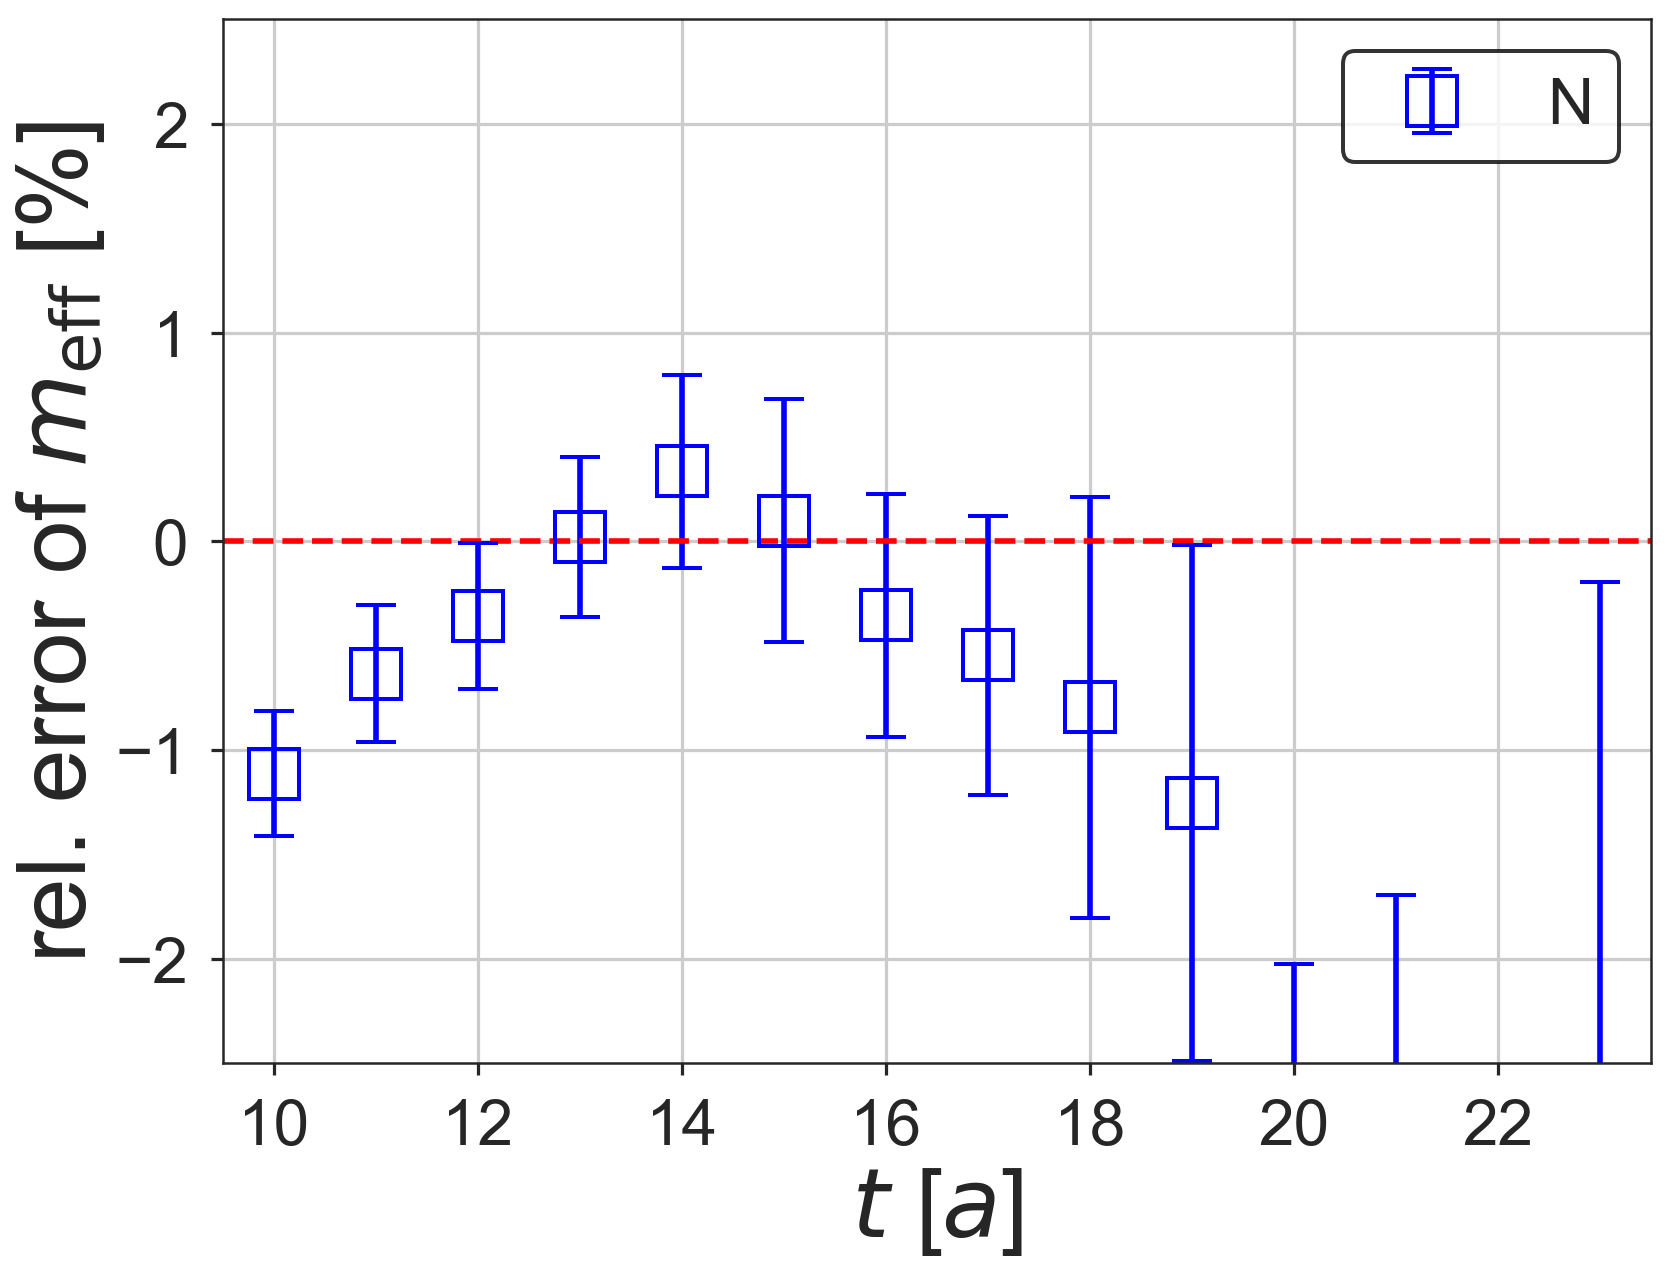

In [23]:
def meff_rela_error(ch, fitr):
    fig, ax = plt.subplots()
    meff_av, meff_err = fit_corr(corr_jk[ch], fitr)
    ax.axhline(0, color='red', ls='--')

    u_err = np.sqrt(1.0/meff_av**2 * meffs[ch][2]**2
                   + (meffs[ch][1]/meff_av**2)**2 * meff_err**2)

    ax.errorbar(meffs[ch][0], (meffs[ch][1]/meff_av - 1)*100, u_err*100,
               fmt='s', capsize=10, capthick=2.5, ms=25, color='blue',
                mfc='none', mew=2.0, label=ch_label[ch])


    ax.set_xlim(9.5, 23.5)
    ax.set_ylim(-2.5, 2.5)
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_xlabel(r'$t$ [$a$]', size=48)
    ax.set_ylabel(r'rel. error of $m_\mathrm{eff}$ [%]', size=48)
    fig.savefig('../figs/meff/rel_error_meff_{}.pdf'.format(ch), bbox_inches='tight')

meff_rela_error('proton', (11.8,  17.2))

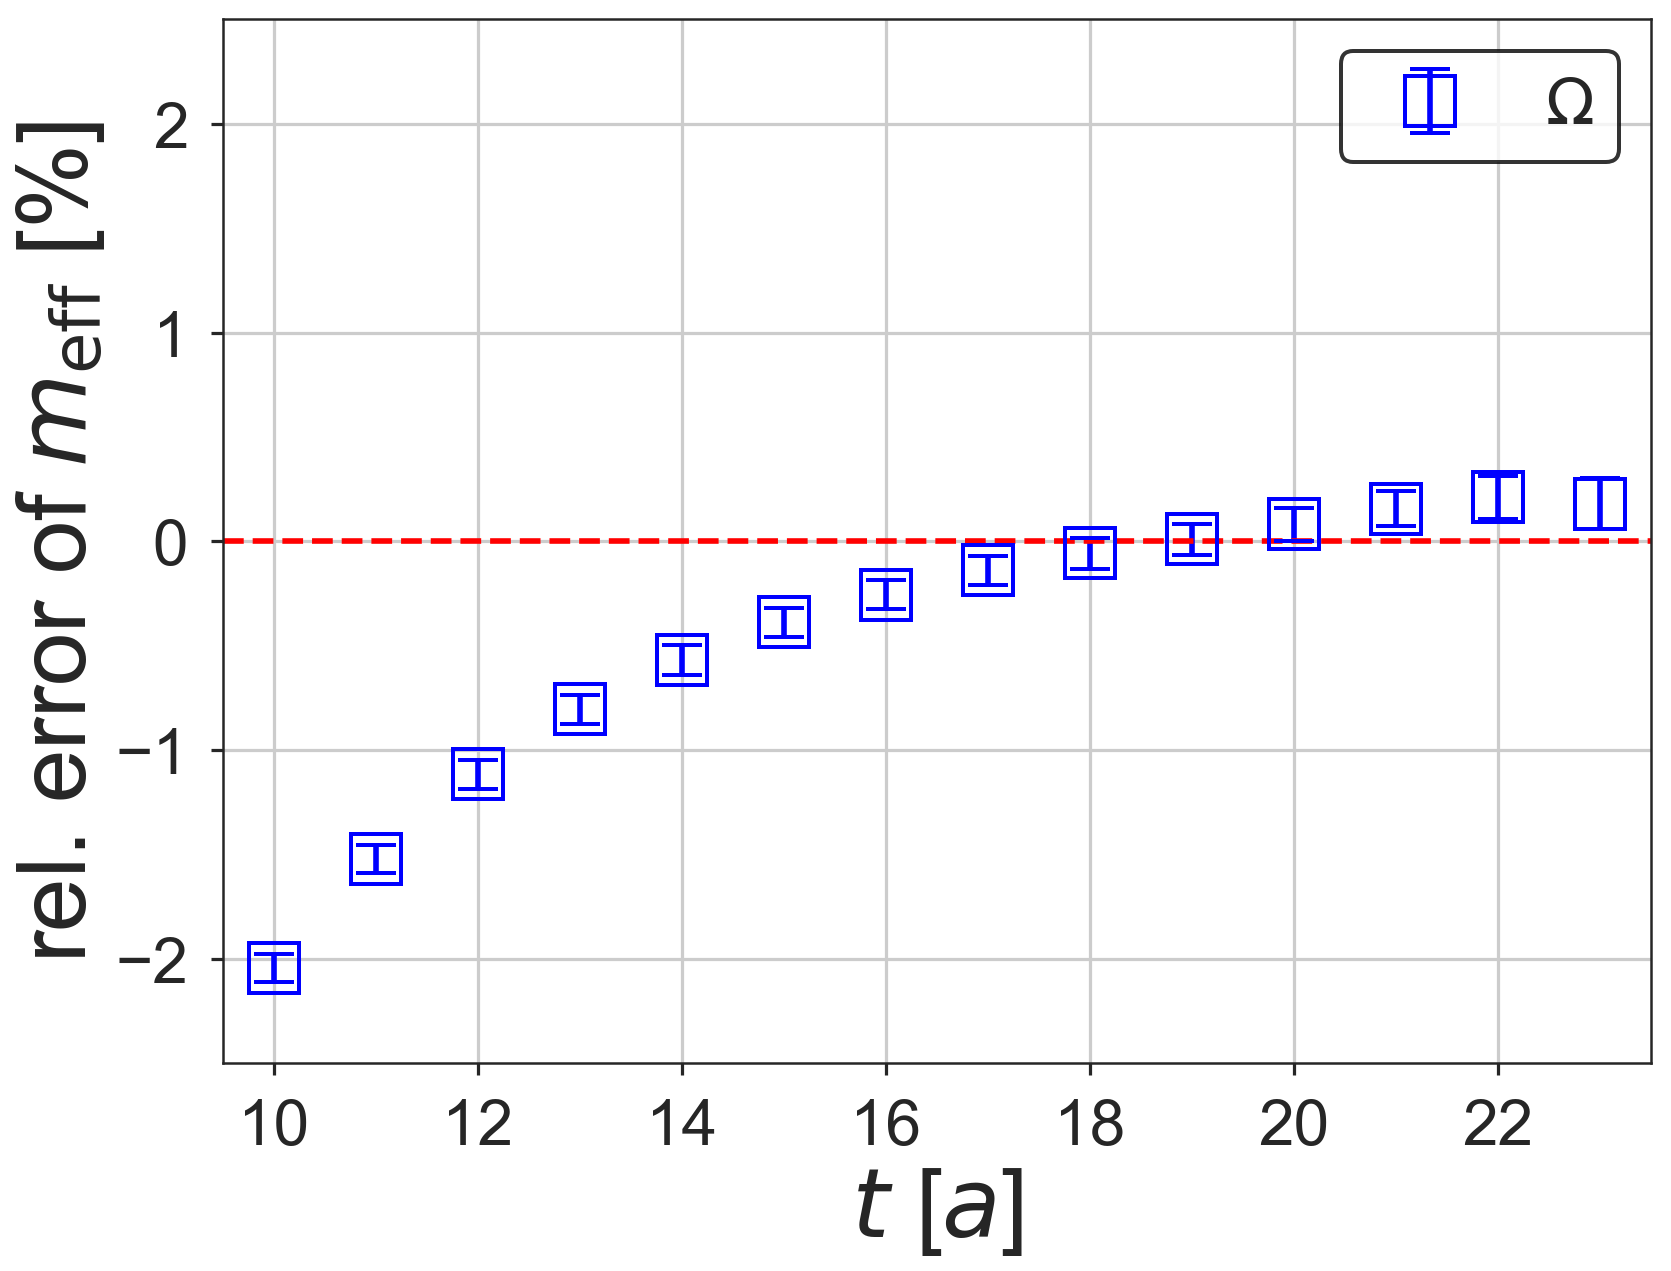

In [24]:
meff_rela_error('OMEGA', (16.8, 22.2))

# threshold energies (without interaction)

In [25]:
mass = {'n': 954.69, 'omega': 1711.53, 'sigma': 1225.61, 'lambda': 1141.67, 'xi': 1353.97}

In [26]:
L = 96
pmin = np.sin(2.0*np.pi/L)*ainv
# minimum momentum
print(pmin , '[MeV]')

152.58550049392377 [MeV]


(2400, 2700)

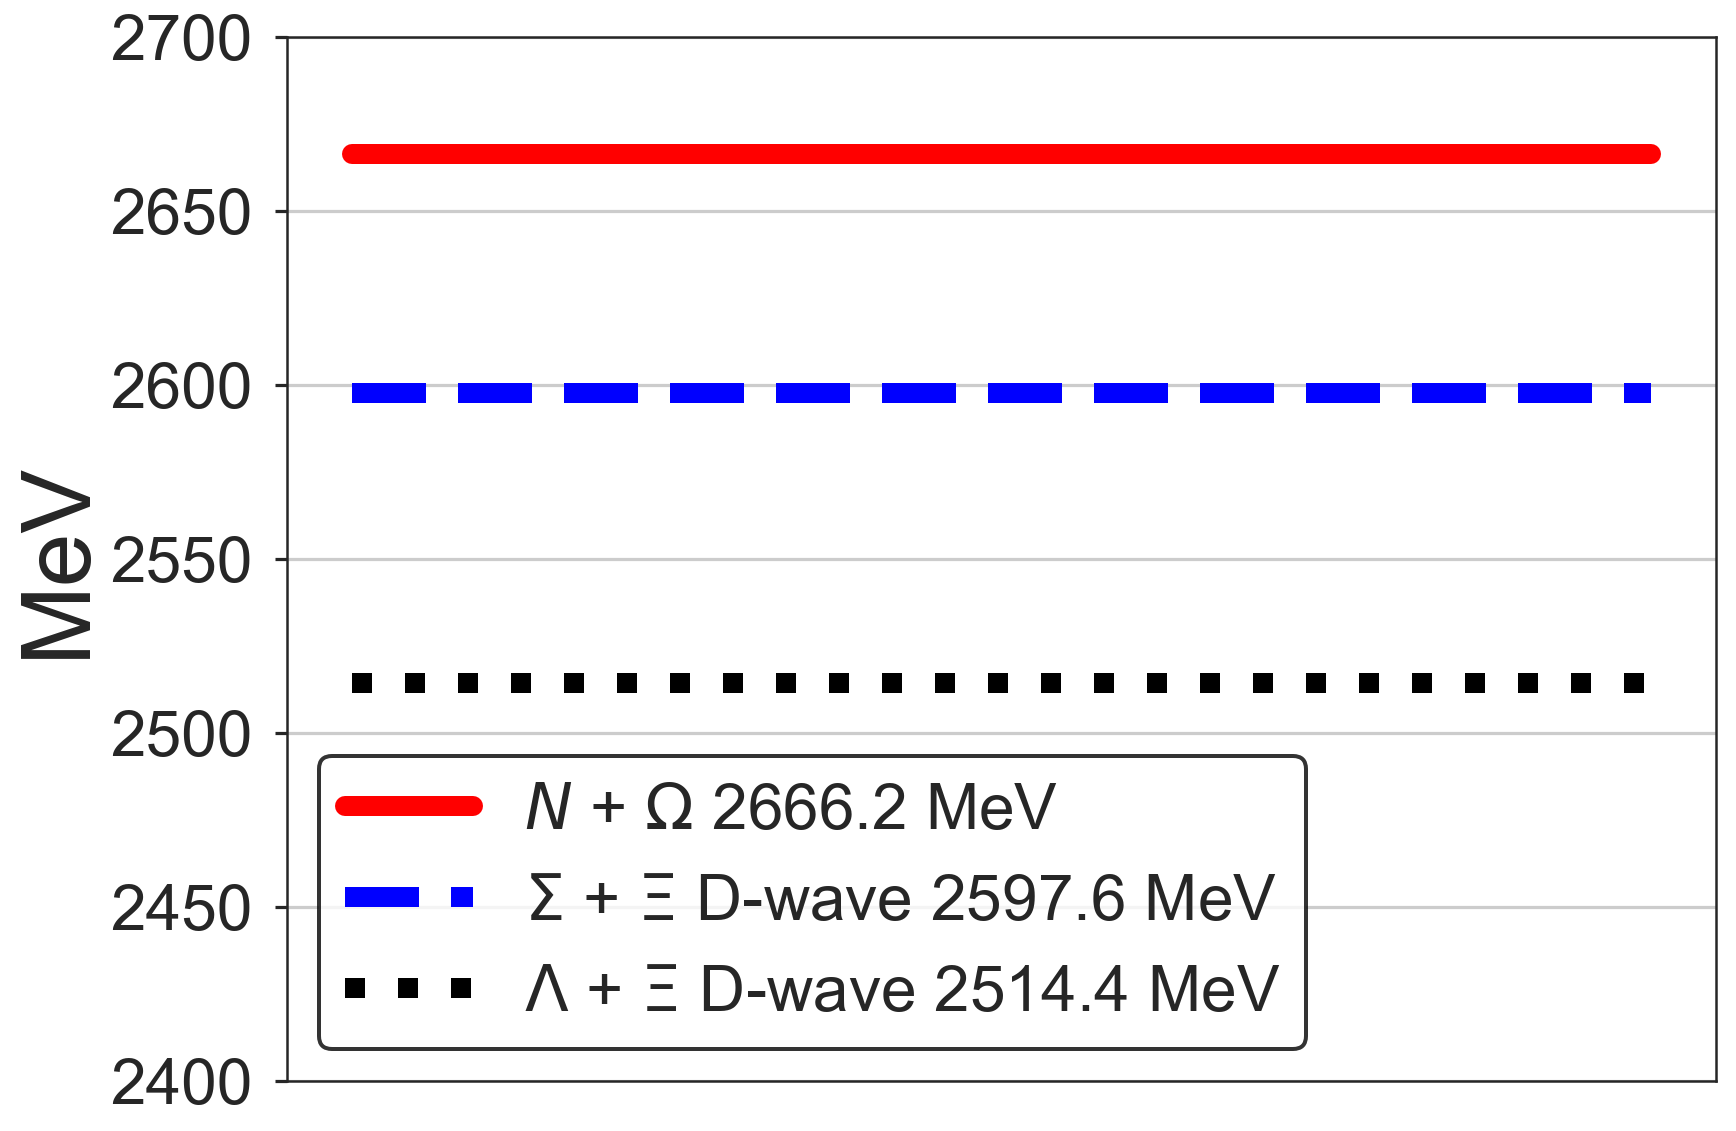

In [27]:
fig, ax = plt.subplots()
L = 96
pmin = np.sin(2.0*np.pi/L)*ainv
ax.plot([0,1], np.zeros_like([0,1]) + mass['n']+mass['omega'], '-',  lw=10, color='red',
        label=r'$N$ + $\Omega$ {:4.1f} MeV'.format(mass['n'] + mass['omega']))

val = np.sqrt(mass['sigma']**2 + pmin**2) +np.sqrt(mass['xi']**2+pmin**2)
ax.plot([0,1], np.zeros_like([0,1]) + val, '--', lw=10, color='blue', label=r'$\Sigma$ + $\Xi$ D-wave {:4.1f} MeV'.format(val))

val = np.sqrt(mass['lambda']**2 + pmin**2) +np.sqrt(mass['xi']**2+pmin**2)
ax.plot([0,1], np.zeros_like([0,1]) + val, ':', lw=10, color='black', label=r'$\Lambda$ + $\Xi$ D-wave {:4.1f} MeV'.format(val))

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_xticks([])
ax.set_ylabel(r'MeV', fontsize=48)
ax.set_ylim(2400, 2700)